In [58]:
import pandas as pd
import numpy as np

data = pd.DataFrame(pd.read_csv("heart_2022_no_nans.csv"))

In [59]:
data = data.drop(columns=["State", "RaceEthnicityCategory"])
data = data.replace("Female", "0")
data = data.replace("Male", "1")
data["AgeCategory"] = data["AgeCategory"].str[4:6]

data["GeneralHealth"] = data["GeneralHealth"].replace({"Poor":"0", "Fair":"1", "Good":"2", "Very good":"3", "Excellent":"4"})
data["LastCheckupTime"] = data["LastCheckupTime"].replace({"Within past year (anytime less than 12 months ago)":"0",
                                                           "Within past 2 years (1 year but less than 2 years ago)": "1",
                                                          "Within past 5 years (2 years but less than 5 years ago)": "2",
                                                          "5 or more years ago": "3"})

data["RemovedTeeth"] = data["RemovedTeeth"].replace({"All": "3", 
                                                     "6 or more, but not all": "2",
                                                     "1 to 5": "1",
                                                     "None of them": "0"
                                                    })


data["HadDiabetes"] = data["HadDiabetes"].replace({"No":"0",
                                                  "No, pre-diabetes or borderline diabetes": "1",
                                                  "Yes, but only during pregnancy (female)": "2",
                                                  "Yes": "3"})

data["SmokerStatus"] = data["SmokerStatus"].replace({"Never smoked": "0",
                                                    "Former smoker": "1",
                                                    "Current smoker - now smokes some days": "2",
                                                    "Current smoker - now smokes every day": "3"})

data["ECigaretteUsage"] = data["ECigaretteUsage"].replace({"Never used e-cigarettes in my entire life": "0",
                                                          "Not at all (right now)": "1",
                                                          "Use them some days": "2",
                                                          "Use them every day":"3"})

data["TetanusLast10Tdap"] = data["TetanusLast10Tdap"].replace({"No, did not receive any tetanus shot in the past 10 years": "0",
                                                              "Yes, received tetanus shot but not sure what type": "1",
                                                              "Yes, received tetanus shot, but not Tdap": "2",
                                                              "Yes, received Tdap": "3"})
data["CovidPos"] = data["CovidPos"].replace({"No":"0", 
                                             "Tested positive using home test without a health professional": "1",
                                             "Yes": "2"})

data = data.replace({"No":"0",
                     "Yes": "1"})

data.head()

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,0,3,4.0,0.0,0,1,9.0,0,0,0,...,1.60,71.67,27.99,0,0,1,1,3,0,0
1,1,3,0.0,0.0,0,1,6.0,0,0,0,...,1.78,95.25,30.13,0,0,1,1,1,0,0
2,1,3,0.0,0.0,0,0,8.0,2,0,0,...,1.85,108.86,31.66,1,0,0,1,0,0,2
3,0,1,5.0,0.0,0,1,9.0,0,0,0,...,1.70,90.72,31.32,0,0,1,1,0,0,2
4,0,2,3.0,15.0,0,1,5.0,1,0,0,...,1.55,79.38,33.07,0,0,1,1,0,0,0


## Підготовка до тренування моделей

In [60]:
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

le = LabelEncoder()
data1 = data.copy(deep=True)


col = list(data.columns)
categorical_features = []
numerical_features = []
for i in data1.columns:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        data1[i] = le.fit_transform(data1[i])
        categorical_features.append(i)

In [61]:
X = data1.drop(['HadHeartAttack'], axis=1)
y = data1['HadHeartAttack']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_initial_train, X_initial_test, y_initial_train, y_initial_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

Одразу масштабуємо та розділяємо дані на набори для тренування та тестування. Балансування класів на всій множині даних призводить до витоку даних та перенавчанню моделі (особливо дерева рішень), також це завадить корректні оцінці моделі на початкових даних. Балансування класів буде відбуватись на тренувальному наборі, тестування моделей - на наборі для тестування.

### Функція валідації моделі

Модель випробовується на початкових даних. Працює як для моделі логістичної регресії, так і для моделі дерева рішень.

In [62]:
all_logreg_logs = pd.DataFrame()
all_dtree_logs = pd.DataFrame()

def validate_model(model, balancing_method_name: str):        
    global all_logreg_logs, all_dtree_logs, X_initial_test, y_initial_test
    
    if isinstance(model, LogisticRegression):
        weights = model.coef_[0]
        intercept = model.intercept_[0]
        
        logits = np.dot(X_initial_test, weights) + intercept
        probabilities = 1 / (1 + np.exp(-logits))
        y_pred_initial = (probabilities >= 0.5).astype(int)
    else:
        probabilities = model.predict_proba(X_initial_test)[:, 1]
        y_pred_initial = model.predict(X_initial_test)
    
    accuracy_initial = accuracy_score(y_initial_test, y_pred_initial)
    precision_initial = precision_score(y_initial_test, y_pred_initial)
    recall_initial = recall_score(y_initial_test, y_pred_initial)
    f1_initial = f1_score(y_initial_test, y_pred_initial)
    roc_auc_initial = roc_auc_score(y_initial_test, probabilities)
    initial_validation_log = pd.DataFrame(data=[accuracy_initial,
                                                precision_initial,
                                                recall_initial,
                                                f1_initial,
                                                roc_auc_initial],
                                          index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
                                          columns=[f"{balancing_method_name}"])
    
    if isinstance(model, LogisticRegression):
        all_logreg_logs = pd.concat([all_logreg_logs, initial_validation_log], axis=1)
        print("\nLogistic Regression")
        print(all_logreg_logs.transpose())
    else:
        all_dtree_logs = pd.concat([all_dtree_logs, initial_validation_log], axis=1)
        print("\nDecision Tree")
        print(all_dtree_logs.transpose())

### Функції тренування моделей

Відбувається почергове тренування спочатку моделі логістичної регресії, а після й моделі дерева рішень. Після ввідбувається валідація кожної моделі та заноситься у загальний лог по всім методам та моделям.

In [63]:
def train_models(X_train_balanced, y_train_balanced, balancing_method_name: str):
    
    logreg_model = train_regression_model(X_train_balanced, y_train_balanced)
    
    dtree_model = train_dtree_model(X_train_balanced, y_train_balanced)

    print("\n\nComparison After Validation")
    validate_model(logreg_model, balancing_method_name)
    validate_model(dtree_model, balancing_method_name)

In [64]:
def train_regression_model(X_train_balanced, y_train_balanced):
    logreg = LogisticRegression(solver="liblinear", penalty="l2", C=0.00001, max_iter=10000)
    logreg.fit(X_train_balanced, y_train_balanced)
    
    return logreg

In [65]:
def train_dtree_model(X_train_balanced, y_train_balanced):
    dtree = DecisionTreeClassifier(random_state=0)
    dtree.fit(X_train_balanced, y_train_balanced)

    return dtree

In [66]:
# Показуємо розподіл після методу балансування
def show_stats(y_balanced, balanced_method_name):
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x=y_balanced, hue=y_balanced, palette="Set2")
    for container in ax.containers:
        ax.bar_label(container, label_type='center', rotation=0, color='white')
    plt.title(f"Розподіл після {balanced_method_name}", size=16)
    plt.show()

## Тренування моделей

Усього було випробовано 9 методів: Random Undersampling, Tomek Links, Edited Nearest Neighbours, One Sided Selection, Neighbourhood Cleaning Rule, AllKNN, NearMiss, Cluster Centroids та Instance Hardness Threshold.

### Without sampling

Перевірка точності моделі без балансування класів. Так ми зможемо зрозуміти якщо модель після балансування класів буде менш точною.

In [67]:
train_models(X_initial_train, y_initial_train, "Without_Sampling")



Comparison After Validation

Logistic Regression
                  Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling  0.946957   0.538106  0.339898  0.416629  0.889924

Decision Tree
                  Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling   0.91259   0.257694  0.302334  0.278235  0.625469


### Random Undersampling

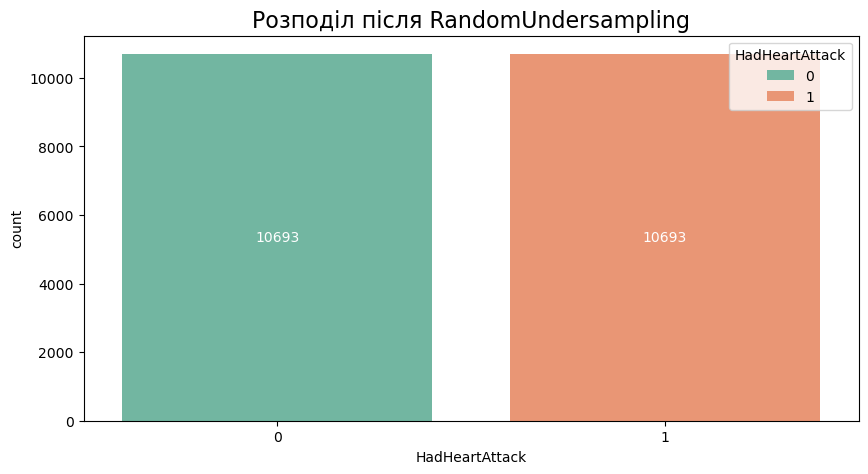

In [68]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

undersample = RandomUnderSampler(sampling_strategy='majority')
X_RUS, y_RUS = undersample.fit_resample(X_initial_train, y_initial_train)

show_stats(y_RUS, "RandomUndersampling")

In [69]:
train_models(X_RUS, y_RUS, "Random Undersampling")



Comparison After Validation

Logistic Regression
                      Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling      0.946957   0.538106  0.339898  0.416629  0.889924
Random Undersampling  0.673753   0.135175  0.899344  0.235025  0.880259

Decision Tree
                      Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling      0.912590   0.257694  0.302334  0.278235  0.625469
Random Undersampling  0.723504   0.132833  0.716630  0.224123  0.720270


### Tomek Links

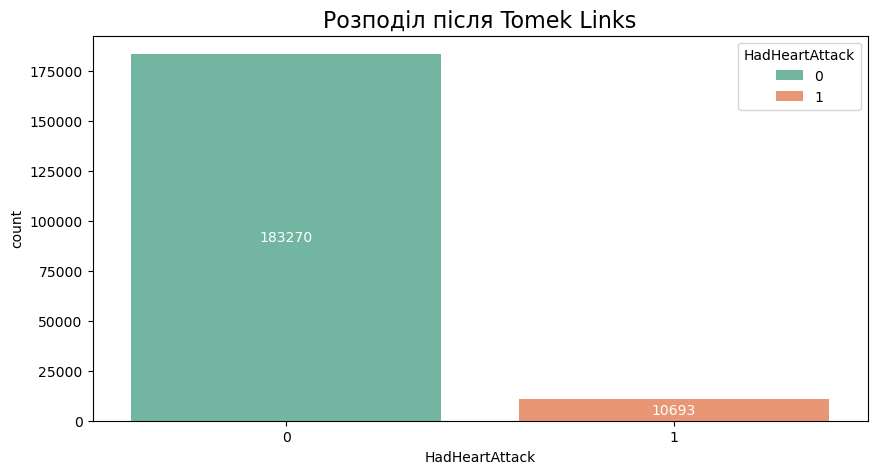

In [70]:
from imblearn.under_sampling import TomekLinks

tomek = TomekLinks()
X_TL, y_TL = tomek.fit_resample(X_initial_train, y_initial_train)

show_stats(y_TL, "Tomek Links")

In [71]:
train_models(X_TL, y_TL, "Tomek_Links")



Comparison After Validation

Logistic Regression
                      Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling      0.946957   0.538106  0.339898  0.416629  0.889924
Random Undersampling  0.673753   0.135175  0.899344  0.235025  0.880259
Tomek_Links           0.944904   0.506941  0.412837  0.455075  0.889884

Decision Tree
                      Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling      0.912590   0.257694  0.302334  0.278235  0.625469
Random Undersampling  0.723504   0.132833  0.716630  0.224123  0.720270
Tomek_Links           0.912712   0.270334  0.333333  0.298546  0.640119


### Edited Nearest Neighbours

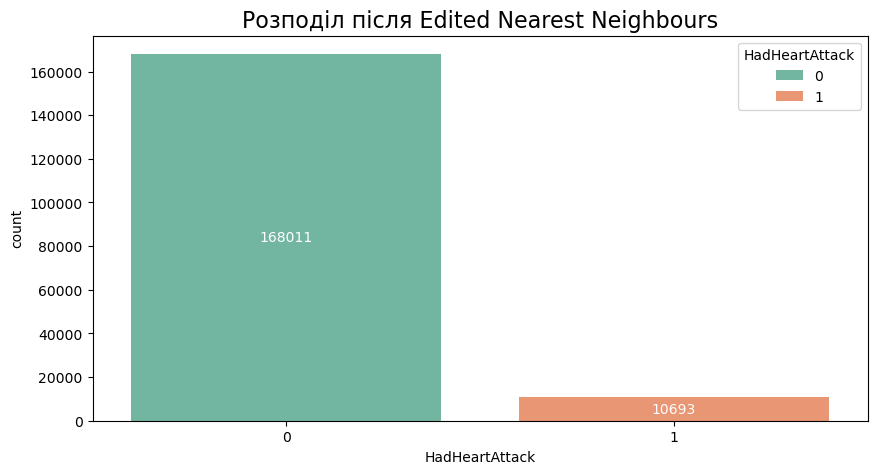

In [72]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours()
X_ENN, y_ENN = enn.fit_resample(X_initial_train, y_initial_train)

show_stats(y_ENN, "Edited Nearest Neighbours")

In [73]:
train_models(X_ENN, y_ENN, "Edited_Nearest_Neighbours")



Comparison After Validation

Logistic Regression
                           Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling           0.946957   0.538106  0.339898  0.416629  0.889924
Random Undersampling       0.673753   0.135175  0.899344  0.235025  0.880259
Tomek_Links                0.944904   0.506941  0.412837  0.455075  0.889884
Edited_Nearest_Neighbours  0.920862   0.368313  0.587527  0.452782  0.888189

Decision Tree
                           Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling           0.912590   0.257694  0.302334  0.278235  0.625469
Random Undersampling       0.723504   0.132833  0.716630  0.224123  0.720270
Tomek_Links                0.912712   0.270334  0.333333  0.298546  0.640119
Edited_Nearest_Neighbours  0.908180   0.297722  0.476659  0.366517  0.705147


### One Sided Selection

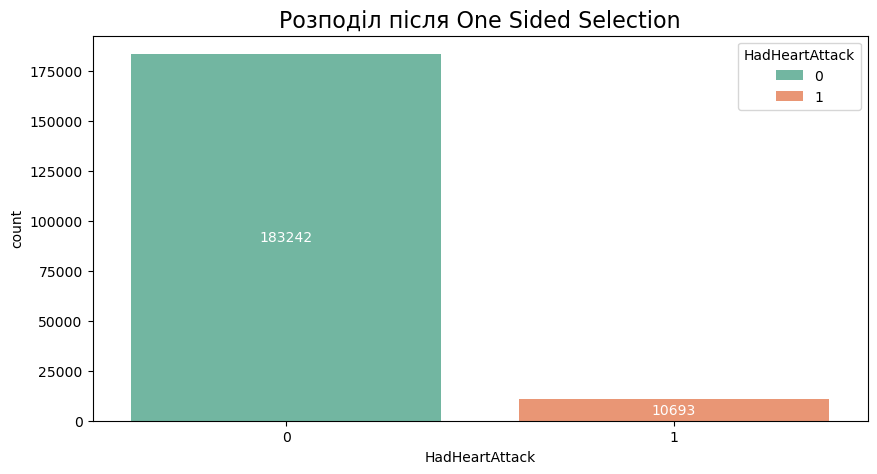

In [74]:
from imblearn.under_sampling import OneSidedSelection

oss = OneSidedSelection()
X_OSS, y_OSS = oss.fit_resample(X_initial_train, y_initial_train)

show_stats(y_OSS, "One Sided Selection")

In [75]:
train_models(X_OSS, y_OSS, "One_Sided_Selection")



Comparison After Validation

Logistic Regression
                           Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling           0.946957   0.538106  0.339898  0.416629  0.889924
Random Undersampling       0.673753   0.135175  0.899344  0.235025  0.880259
Tomek_Links                0.944904   0.506941  0.412837  0.455075  0.889884
Edited_Nearest_Neighbours  0.920862   0.368313  0.587527  0.452782  0.888189
One_Sided_Selection        0.944863   0.506494  0.412473  0.454673  0.889892

Decision Tree
                           Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling           0.912590   0.257694  0.302334  0.278235  0.625469
Random Undersampling       0.723504   0.132833  0.716630  0.224123  0.720270
Tomek_Links                0.912712   0.270334  0.333333  0.298546  0.640119
Edited_Nearest_Neighbours  0.908180   0.297722  0.476659  0.366517  0.705147
One_Sided_Selection        0.913017   0.275671  0.344639  0.306321  0.645599


### Neighbourhood Cleaning Rule

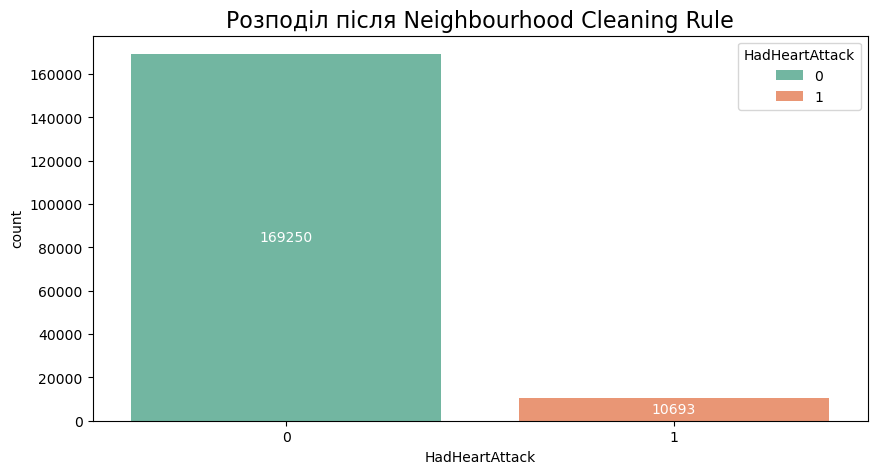

In [76]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

ncr = NeighbourhoodCleaningRule()
X_NCR, y_NCR = ncr.fit_resample(X_initial_train, y_initial_train)

show_stats(y_NCR, "Neighbourhood Cleaning Rule")

In [77]:
train_models(X_NCR, y_NCR, "Neighbourhood_Cleaning_Rule")



Comparison After Validation

Logistic Regression
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.946957   0.538106  0.339898  0.416629  0.889924
Random Undersampling         0.673753   0.135175  0.899344  0.235025  0.880259
Tomek_Links                  0.944904   0.506941  0.412837  0.455075  0.889884
Edited_Nearest_Neighbours    0.920862   0.368313  0.587527  0.452782  0.888189
One_Sided_Selection          0.944863   0.506494  0.412473  0.454673  0.889892
Neighbourhood_Cleaning_Rule  0.928117   0.398207  0.567104  0.467880  0.888861

Decision Tree
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.912590   0.257694  0.302334  0.278235  0.625469
Random Undersampling         0.723504   0.132833  0.716630  0.224123  0.720270
Tomek_Links                  0.912712   0.270334  0.333333  0.298546  0.640119
Edited_Nearest_Neighbours    0.908180   0.297722  0.476659  0.366

### All KNN

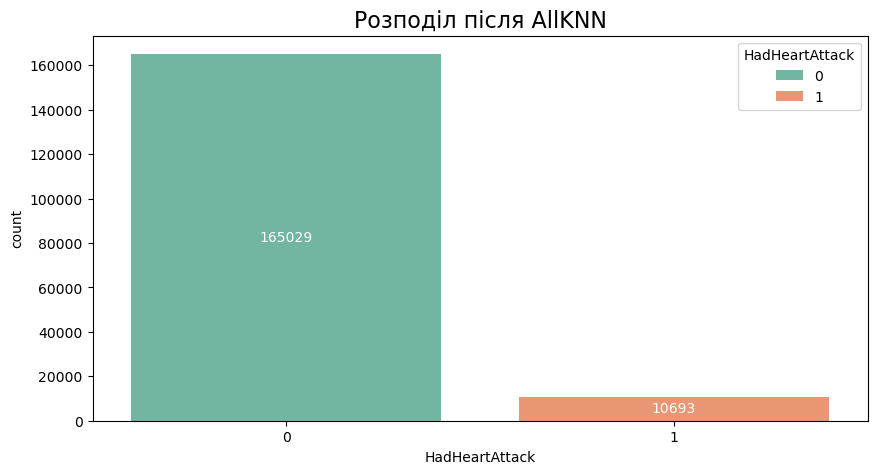

In [78]:
from imblearn.under_sampling import AllKNN

allknn = AllKNN()
X_AllKNN, y_AllKNN = allknn.fit_resample(X_initial_train, y_initial_train)

show_stats(y_AllKNN, "AllKNN")

In [79]:
train_models(X_AllKNN, y_AllKNN, "All_KNN")



Comparison After Validation

Logistic Regression
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.946957   0.538106  0.339898  0.416629  0.889924
Random Undersampling         0.673753   0.135175  0.899344  0.235025  0.880259
Tomek_Links                  0.944904   0.506941  0.412837  0.455075  0.889884
Edited_Nearest_Neighbours    0.920862   0.368313  0.587527  0.452782  0.888189
One_Sided_Selection          0.944863   0.506494  0.412473  0.454673  0.889892
Neighbourhood_Cleaning_Rule  0.928117   0.398207  0.567104  0.467880  0.888861
All_KNN                      0.913058   0.342881  0.611233  0.439318  0.887832

Decision Tree
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.912590   0.257694  0.302334  0.278235  0.625469
Random Undersampling         0.723504   0.132833  0.716630  0.224123  0.720270
Tomek_Links                  0.912712   0.270334  0.333333  0.298

### NearMiss

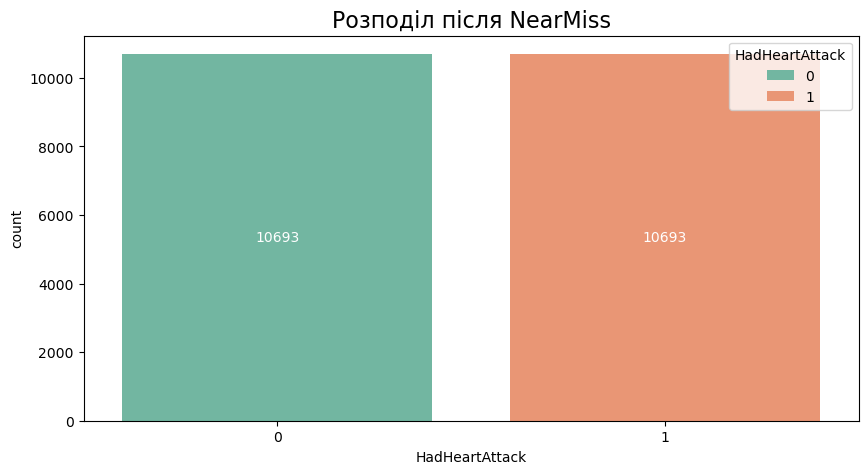

In [80]:
from imblearn.under_sampling import NearMiss

nearmiss = NearMiss()
X_NearMiss, y_NearMiss = nearmiss.fit_resample(X_initial_train, y_initial_train)

show_stats(y_NearMiss, "NearMiss")

In [81]:
train_models(X_NearMiss, y_NearMiss, "Near_Miss")



Comparison After Validation

Logistic Regression
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.946957   0.538106  0.339898  0.416629  0.889924
Random Undersampling         0.673753   0.135175  0.899344  0.235025  0.880259
Tomek_Links                  0.944904   0.506941  0.412837  0.455075  0.889884
Edited_Nearest_Neighbours    0.920862   0.368313  0.587527  0.452782  0.888189
One_Sided_Selection          0.944863   0.506494  0.412473  0.454673  0.889892
Neighbourhood_Cleaning_Rule  0.928117   0.398207  0.567104  0.467880  0.888861
All_KNN                      0.913058   0.342881  0.611233  0.439318  0.887832
Near_Miss                    0.664282   0.126174  0.847921  0.219661  0.834961

Decision Tree
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.912590   0.257694  0.302334  0.278235  0.625469
Random Undersampling         0.723504   0.132833  0.716630  0.224

### Cluster Centroids

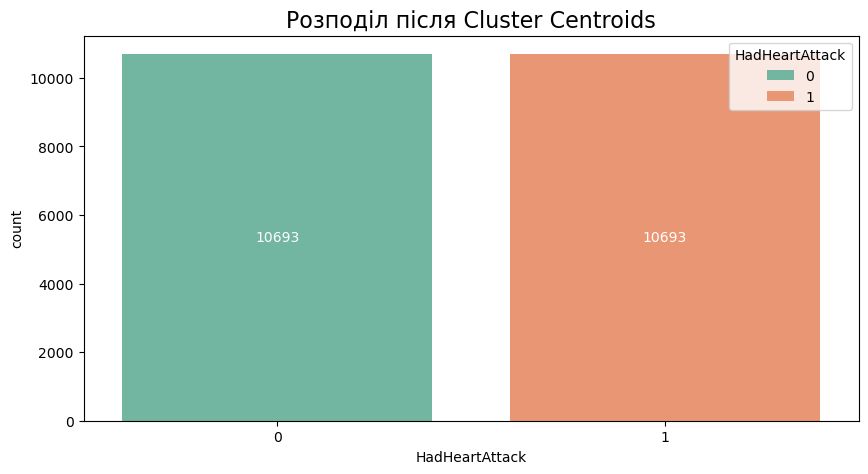

In [82]:
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import KMeans

cc = ClusterCentroids(estimator=KMeans(n_clusters=10, random_state=42))
X_ClusterCentroids, y_ClusterCentroids = cc.fit_resample(X_initial_train, y_initial_train)

show_stats(y_ClusterCentroids, "Cluster Centroids")

In [83]:
train_models(X_ClusterCentroids, y_ClusterCentroids, "Cluster_Centroids")



Comparison After Validation

Logistic Regression
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.946957   0.538106  0.339898  0.416629  0.889924
Random Undersampling         0.673753   0.135175  0.899344  0.235025  0.880259
Tomek_Links                  0.944904   0.506941  0.412837  0.455075  0.889884
Edited_Nearest_Neighbours    0.920862   0.368313  0.587527  0.452782  0.888189
One_Sided_Selection          0.944863   0.506494  0.412473  0.454673  0.889892
Neighbourhood_Cleaning_Rule  0.928117   0.398207  0.567104  0.467880  0.888861
All_KNN                      0.913058   0.342881  0.611233  0.439318  0.887832
Near_Miss                    0.664282   0.126174  0.847921  0.219661  0.834961
Cluster_Centroids            0.634082   0.121021  0.888767  0.213034  0.870225

Decision Tree
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.912590   0.257694  0.302334  0.278

### Instance Hardness Threshold

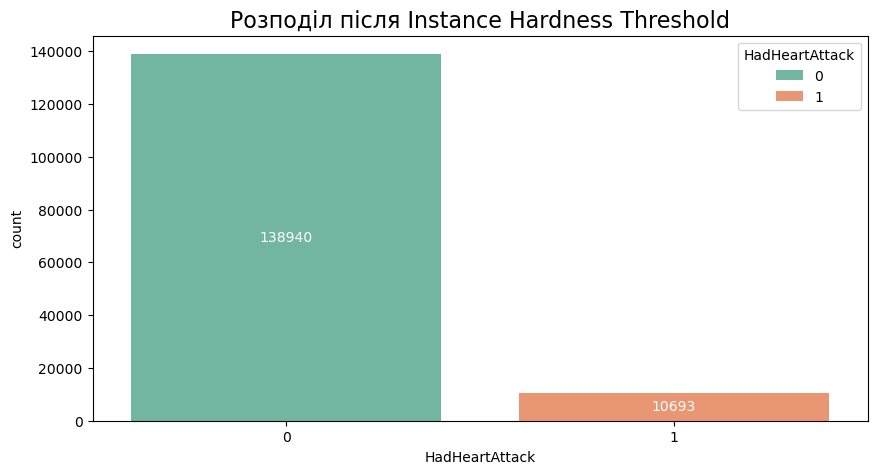

In [84]:
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.ensemble import RandomForestClassifier

iht = InstanceHardnessThreshold(estimator=RandomForestClassifier(n_estimators=10, random_state=42))
X_IHT, y_IHT = iht.fit_resample(X_initial_train, y_initial_train)

show_stats(y_IHT, "Instance Hardness Threshold")

In [85]:
train_models(X_IHT, y_IHT, "Instance_Hardness_Threshold")



Comparison After Validation

Logistic Regression
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.946957   0.538106  0.339898  0.416629  0.889924
Random Undersampling         0.673753   0.135175  0.899344  0.235025  0.880259
Tomek_Links                  0.944904   0.506941  0.412837  0.455075  0.889884
Edited_Nearest_Neighbours    0.920862   0.368313  0.587527  0.452782  0.888189
One_Sided_Selection          0.944863   0.506494  0.412473  0.454673  0.889892
Neighbourhood_Cleaning_Rule  0.928117   0.398207  0.567104  0.467880  0.888861
All_KNN                      0.913058   0.342881  0.611233  0.439318  0.887832
Near_Miss                    0.664282   0.126174  0.847921  0.219661  0.834961
Cluster_Centroids            0.634082   0.121021  0.888767  0.213034  0.870225
Instance_Hardness_Threshold  0.843471   0.224628  0.737783  0.344399  0.878473

Decision Tree
                             Accuracy  Precision    Recall  F1-sc

### Висновки

Виходячи з даних результатів я можу зробити 2 головних висновки:
1. Як і для підходу oversampling, дерева рішень працюють гірше за логістичну регресію в даному випадку. До того ж лише Instance Hardness Threshold зміг значно підвищити загальну точність моделі, припускаю причина цього в тому, що це єдиний метод балансування з використаних, що враховує складність усієї структури даних, а не лише найближчих сусідів.
2. Жоден метод undersampling балансування не зміг значно підвищити загальної точності логістичної регресії. Кожна модель має низький Precision (0.2-0.45), тобто близько поливина чи більше передбачень серцевих нападів будуть неправдивими для усіх підходів. Хоча деякі моделі добре передбачують реальні випадки серцевих нападів (Recall > 0.7), але робиться це за рахунок дуже великої кількості передбачень, більшість з яких все ж таки неправдиві (через що маємо стабільно низький Precision).

У випадку з методами "зрівняння" кількості позитивних та негативних випадків, як ось Random Undersampling, NearMiss та Cluster Centroids, отримуємо малу вибірку, всього близько 20 тис. записів суммарно. Також ми таким чином видаляємо дуже багато потенційно важливої інформації. (Важливість якої складно оцінити через велику кількіст параметрів у даних, близько 40 штук)

У випадку з методами зменшення шумів, я думаю, ми не отримуємо приросту точності через те, що дані попередньо очищені.

Хоча результаті жоден з undersampling методів балансування класів не запропонував збільшення загальної точності моделі, але **TomekLinks та One Sided Selection дають гарний зріст в Recall на 7 пунктів в обмін на 3 пункти Precision**.

In [29]:
with pd.ExcelWriter('undersampling_comparison.xlsx') as writer:
    all_logreg_logs.transpose().to_excel(writer, sheet_name='LogisticRegression', index=False)
    all_dtree_logs.transpose().to_excel(writer, sheet_name='DecisionTree', index=False)

print("Excel файл успішно створено")

Excel файл успішно створено
